# Regularization Techniques

Version 1.0

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

The purpose of this notebook is to show you an example of extreme overfitting in the case of a linear regression model applied to a dataset taken from the real world. Then a series of strategies are presented (called regularization techniques) which can help us try to solve this issue, without the need of changing the network's architecture or the model itself.

## Notebook Learning Goals

At the end of this notebook you will clearly know what overfitting is and how to treat it by means of regularization and dropout techniques. In particular you will know how to implement in Keras $L_2$ and $L_1$ regularization techniques, dropout and early stopping.

## Libraries and Dataset Import

This section contains the necessary libraries (such as tensorflow or pandas) you need to import to run the notebook.

In [2]:
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# sklearn libraries
#from sklearn.datasets import load_boston

In this notebook we will use the **Boston dataset**. Check the [Further Readings](#fr) section to have more details about this dataset. It is very straightforward to import, by means of scikit-learn library, which already contains the dataset, ready to be used. The following cells are needed to automatically download the dataset and have it in the notebook.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113
)


## The Boston Dataset

The "Boston dataset," also known as the "Boston Housing dataset," is a well-known dataset in the field of machine learning and statistics. It was originally collected by the statistician Harrison R. Crerar in the 1970s and later made famous by David Harrison and Daniel Rubinfield, who used it in their 1978 paper "Hedonic Prices and the Demand for Clean Air." The dataset is often used for regression analysis, particularly in the context of predictive modeling and housing market research. Here's a description of the Boston dataset:

**Description**:

The Boston dataset contains information about housing attributes in various neighborhoods of Boston, Massachusetts. It is commonly used to explore the relationships between different factors and the median value of owner-occupied homes (also known as the target variable or dependent variable). The dataset includes a total of 506 data points, each representing a different neighborhood.

**Features**:

1. **CRIM**: Per capita crime rate by town.
2. **ZN**: Proportion of residential land zoned for large lots (over 25,000 sq. ft.).
3. **INDUS**: Proportion of non-retail business acres per town.
4. **CHAS**: Charles River dummy variable (1 if tract bounds river; 0 otherwise).
5. **NOX**: Nitrogen oxide concentration (parts per 10 million).
6. **RM**: Average number of rooms per dwelling.
7. **AGE**: Proportion of owner-occupied units built before 1940.
8. **DIS**: Weighted distance to employment centers.
9. **RAD**: Index of accessibility to radial highways.
10. **TAX**: Property tax rate (in dollars per $10,000).
11. **PTRATIO**: Pupil-teacher ratio by town.
12. **B**: Proportion of residents of African American descent.
13. **LSTAT**: Percentage of lower status population.
14. **MEDV**: Median value of owner-occupied homes (the target variable).

**Use Cases**:

Researchers, data scientists, and machine learning practitioners often use the Boston dataset for various purposes:

1. **Regression Analysis**: It is commonly used for regression tasks to predict the median home value based on the given features.

2. **Feature Engineering**: Practitioners use this dataset to demonstrate and practice feature engineering techniques.

3. **Model Testing**: It serves as a valuable dataset for testing and evaluating regression algorithms and models.

4. **Teaching and Learning**: The Boston dataset is often used in educational settings to teach concepts related to linear regression, data analysis, and machine learning.

5. **Benchmarking**: It can be used as a benchmark for evaluating the performance of new regression algorithms or techniques.


Let's get the dimension of the data set now.

In [8]:
n_training_samples = X_train.shape[0]
n_dim = X_train.shape[1]

print('The dataset has', n_training_samples, 'training samples.')
print('The dataset has', n_dim, 'features.')

The dataset has 404 training samples.
The dataset has 13 features.


So, in the variable `n_training_samples` we have the number of different input observations, and in the variable `n_dim` we have the number of features (or variables if you like) that we have at our disposal.

## Dataset Normalization

The following function is needed to normalize the different features, since this helps learning. As you can see, this is done by means of NumPy wonderful vectorized code.

In [9]:
def normalize(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset - mu)/sigma

In [10]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

## Extreme Overfitting

Now we will use the Boston dataset to go into a situation of extreme ovefitting. We will apply a **linear regression** model performed by means of deep neural networks to the Boston dataset. If you don't remember the details of linear regression implemented with deep neural networks you can check *Linear_regression_with_one_neuron.ipynb* notebook, in Chapter 14. 

First of all, **we split our dataset** into training (80% of the original dataset) and dev (20% of the original dataset) sets.

In [32]:
#
# IMPORTANT: This cell is only for compatibility with older version of this notebook.
#

np.random.seed(42)
train_x = X_train_norm
train_y = y_train
dev_x = X_test_norm
dev_y = y_test

print(train_x.shape)
print(train_y.shape)
print(dev_x.shape)
print(dev_y.shape)

(404, 13)
(404,)
(102, 13)
(102,)


Let's look at what happens when we try to do linear regression with a network with **4 layers with 20 neurons each**.

The following function builds and trains a feed-forward neural network model for linear regression and evaluates it on the training and dev sets. If you don't remember what a feed-forward neural network is, you can check the *Multiclass_classification_with_fully_connected_networks.ipynb* notebook in Chapter 15.

In [42]:
def create_and_train_model_nlayers(data_train_norm, labels_train, data_dev_norm, labels_dev, num_neurons, num_layers):
    # build model
    inputs = keras.Input(shape = data_train_norm.shape[1]) # input layer
    # he initialization
    initializer = tf.keras.initializers.HeNormal()
    # first hidden layer
    dense = layers.Dense(num_neurons, activation = 'relu', kernel_initializer = initializer)(inputs)
    # customized number of layers and neurons per layer
    for i in range(num_layers - 1):       
        dense = layers.Dense(num_neurons, activation = 'relu', kernel_initializer = initializer)(dense)
    # output layer   
    outputs = layers.Dense(1)(dense)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'model')
    # set optimizer and loss
    #opt = keras.optimizers.Adam(learning_rate = 0.001) # This runs slow on M1/M2 macs in Jan 2024
    opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
    model.compile(loss = 'mse', optimizer = opt, metrics = ['mse'])
    
    # train model
    history = model.fit(
      data_train_norm, labels_train,
      epochs = 3000, verbose = 0,
      batch_size = 500,
      validation_data = (data_dev_norm, labels_dev))
    # save performances
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch 

    return hist, model

In [39]:
hist, model = create_and_train_model_nlayers(train_x, train_y, dev_x, dev_y, 20, 4)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Now we want to plot the **dev vs training mean square error (MSE)** to understand if we are in overfitting regime.

### Cost Function on the Training and Dev Dataset Plot

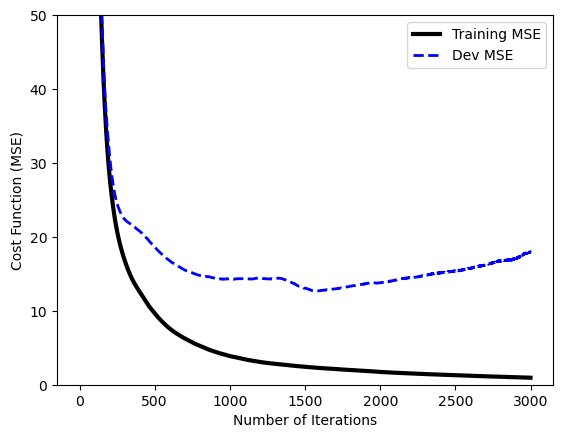

In [43]:
# Cost Function vs. Number of Iterations plot for training and dev datasets

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(hist['loss'], ls = '-', color = 'black', lw = 3, label = 'Training MSE')
ax.plot(hist['val_loss'], ls = '--', color = 'blue', lw = 2, label = 'Dev MSE')
plt.ylabel('Cost Function (MSE)')
plt.xlabel('Number of Iterations')
ax.set_ylim(0, 50)
plt.legend(loc = 'best')

plt.axis(True)
plt.show()

As you can see from the above plot, we are in a situation of **extreme overfitting**. In fact, while the error on the training dataset quickly reaches the zero, the error on the dev dataset reaches a value of 15 and then it starts increasing until a value of 20. This means that our model has learnt useless features of the training dataset (for example noise) and that it cannot generalize on newly unseen data samples.

Another easy way of checking how our regression model is working is to plot the predicted values vs. the true values for both the training and dev datasets. If our regression would be perfect, all the points would be placed on the diagonal, if not they would spread around it.

In [44]:
# predictions
pred_y_train = model.predict(train_x).flatten()
pred_y_dev = model.predict(dev_x).flatten()

13/13 [==============================] - 0s 578us/step


4/4 [==============================] - 0s 706us/step


### Predicted Values vs. True Values on Training and Dev Dataset Plot

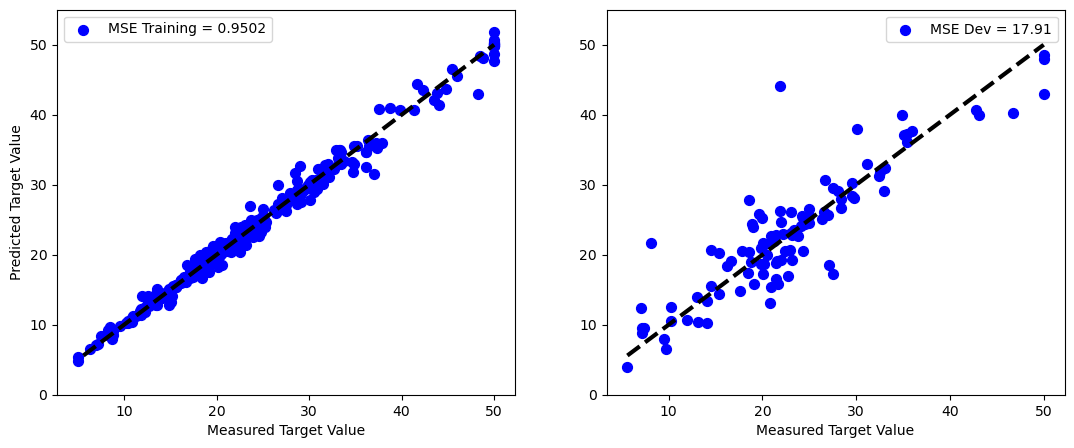

In [45]:
# predicted values vs. true values plot for training and dev datasets

fig = plt.figure(figsize = (13, 5))
ax = fig.add_subplot(121)

ax.scatter(train_y, pred_y_train, s = 50, color = 'blue', label = 'MSE Training = ' + '{:5.4f}'.format(hist['loss'].values[-1]))
ax.plot([np.min(np.array(dev_y)), np.max(np.array(dev_y))], [np.min(np.array(dev_y)), np.max(np.array(dev_y))], 'k--', lw = 3)
ax.set_xlabel('Measured Target Value')
ax.set_ylabel('Predicted Target Value')
ax.set_ylim(0, 55)
ax.legend(loc = 'best')

ax = fig.add_subplot(122)
ax.scatter(dev_y, pred_y_dev, s = 50, color = 'blue', label = 'MSE Dev = ' + '{:5.2f}'.format(hist['val_loss'].values[-1]))
ax.plot([np.min(np.array(dev_y)), np.max(np.array(dev_y))], [np.min(np.array(dev_y)), np.max(np.array(dev_y))], 'k--', lw = 3)
ax.set_xlabel('Measured Target Value')
ax.set_ylim(0, 55)
ax.legend(loc = 'best')

plt.axis(True)
#plt.savefig('./Figure16-2.png', dpi = 300)
plt.show()

And, as expected, the model behaves perfectly on the training dataset and poorly on the dev dataset. In the left plot all the points stand on the diagonal line, with a very low MSE, while in the right plot the points are more scattered and the MSE increases. This means that the predictions on the dev test are quite different from the target labels.

So, the natural question now is: why does the model go into overfitting regime? How to avoid it? The answer to the first question is quite easy and it is linked to the complexity of our network: too many layers and too many neurons learn useless information from the training dataset.

Concerning the second question, there are many ways to try to reduce overfitting. The most straightforward is to reduce the complexity of the network. However, this is a very time-consuming process, mostly when we have very big datasets which require time to be trained. In fact we have to try different architecture and decide which is the right one. 

*An alternative solution to the problem of overfitting is regularization.* Let us see more in detail how to perform it.

## Regularization

We are now going to try a regularization method to deal with the problem of overfitting. 

First of all, it is important to know that the concept of **regularization** in machine learning has a long history, starting from the 90s, and evolving over time. If you are interest in different views on what regularization means, check the [Further Readings](#fr) section of the notebook.

In this notebook, we will consider regularization as a way to try to avoid overfitting.  More specifically, this is achieved by reducing the number of network's weights which are not zero, during the training phase. 

We will start from **${\bf L_2}$ regularization technique**, which consists of adding a term to the cost function with the aim of reducing the effective capacity of the network to adapt to complex datasets.

### **$L_2$ Regularization Technique**

Applying $L_2$ regularization technique, the cost function is defined as follow

$$
\tilde{J}({\bf w})={J({\bf w})+\frac{\lambda}{2m}{||{\bf w}||}^2}_2 
$$

where ${\frac{\lambda}{2m}{||{\bf w}||}^2}_2$ is called the **regularization term** ($m$ is the number of observations) and $\lambda$ is called the **regularization parameter**.

We will define $\lambda$ in Keras as an additional hyper-parameter and we will search for its optimal value (i.e. the one that prevents the network from going into overfitting regime). 

Notice that in Keras the $L_2$ regularization penalty is computed as: `loss = l2 * reduce_sum(square(x))`.

In [46]:
def create_and_train_reg_model_L2(data_train_norm, labels_train, data_dev_norm, labels_dev, num_neurons, num_layers, n_epochs, lambda_):
    # build model
    inputs = keras.Input(shape = data_train_norm.shape[1]) # input layer
    # he initialization
    initializer = tf.keras.initializers.HeNormal()
    # regularization
    reg = tf.keras.regularizers.l2(l2 = lambda_)
    # first hidden layer
    dense = layers.Dense(num_neurons, activation = 'relu', kernel_initializer = initializer, kernel_regularizer = reg)(inputs)
    # customized number of layers and neurons per layer
    for i in range(num_layers - 1):       
        dense = layers.Dense(num_neurons, activation = 'relu', kernel_initializer = initializer, kernel_regularizer = reg)(dense)
    # output layer   
    outputs = layers.Dense(1)(dense)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'model')
    # set optimizer and loss
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'mse', optimizer = opt, metrics = ['mse'])
    
    # train model
    history = model.fit(
      data_train_norm, labels_train,
      epochs = n_epochs, verbose = 0,
      batch_size = data_train_norm.shape[0],
      validation_data = (data_dev_norm, labels_dev))
    # save performances
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch 
    # print performances
    print('Cost function at epoch 0')
    print('Training MSE = ', hist['loss'].values[0])
    print('Dev MSE = ', hist['val_loss'].values[0])
    print('Cost function at epoch ' + str(n_epochs))
    print('Training MSE = ', hist['loss'].values[-1])
    print('Dev MSE = ', hist['val_loss'].values[-1])

    return hist, model

#### Number of Weights that are Zero

Let us evaluate and compare a situation in which the network is not regularized ($\lambda = 0.0$) and a situation in which we apply a regularization ($\lambda = 10.0$), printing on the screen the final loss function value in the case of the training and dev dataset.

##### $\lambda = 0.0$ vs $\lambda = 10.0$, $5000$ epochs

In [47]:
hist_notreg, model_notreg = create_and_train_reg_model_L2(train_x, train_y, dev_x, dev_y, 20, 4, 5000, 0.0)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  549.9962768554688
Dev MSE =  571.0113525390625
Cost function at epoch 5000
Training MSE =  0.15469498932361603
Dev MSE =  24.648578643798828


In [48]:
hist_reg, model_reg = create_and_train_reg_model_L2(train_x, train_y, dev_x, dev_y, 20, 4, 5000, 10.0)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  2189.541015625
Dev MSE =  2202.03466796875
Cost function at epoch 5000
Training MSE =  55.4620361328125
Dev MSE =  53.50596618652344


As we said before, $L_2$ regularization reduces the number of network's weights which are not zero, during the training phase, and prevent the overfitting situation (in fact, as you can see, the MSE on the training and test after 5000 epochs are quite similar). Let us inspect how the weights have changed after regularization.

Let us first check how many weights have been reduced to zero during the regularization process.

The following lines extract the weights associated to each hidden layer in the case of the regularized version of the network and the not regularized one.

In [49]:
# not regularized network
weights1_notreg = model_notreg.layers[1].get_weights()[0]
weights2_notreg = model_notreg.layers[2].get_weights()[0]
weights3_notreg = model_notreg.layers[3].get_weights()[0]
weights4_notreg = model_notreg.layers[4].get_weights()[0]

In [50]:
# regularized network
weights1_reg = model_reg.layers[1].get_weights()[0]
weights2_reg = model_reg.layers[2].get_weights()[0]
weights3_reg = model_reg.layers[3].get_weights()[0]
weights4_reg = model_reg.layers[4].get_weights()[0]

Now we print the percentage of weights equal to zero inside each hidden layer.

In [51]:
print('NOT REGULARIZED NETWORK')
print('First hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights1_notreg) < 1e-3)) / weights1_notreg.size * 100.0))
print('Second hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights2_notreg) < 1e-3)) / weights2_notreg.size * 100.0))
print('Third hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights3_notreg) < 1e-3)) / weights3_notreg.size * 100.0))
print('Fourth hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights4_notreg) < 1e-3)) / weights4_notreg.size * 100.0))

NOT REGULARIZED NETWORK
First hidden layer:
0.77
Second hidden layer:
0.25
Third hidden layer:
0.25
Fourth hidden layer:
0.00


In [52]:
print('REGULARIZED NETWORK')
print('First hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights1_reg) < 1e-3)) / weights1_reg.size * 100.0))
print('Second hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights2_reg) < 1e-3)) / weights2_reg.size * 100.0))
print('Third hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights3_reg) < 1e-3)) / weights3_reg.size * 100.0))
print('Fourth hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights4_reg) < 1e-3)) / weights4_reg.size * 100.0))

REGULARIZED NETWORK
First hidden layer:
15.38
Second hidden layer:
51.50
Third hidden layer:
49.00
Fourth hidden layer:
37.25


We can then compare the histogram of the weights with and without regularization (to have a more intuitive representation of the weights). The difference is quite stunning.

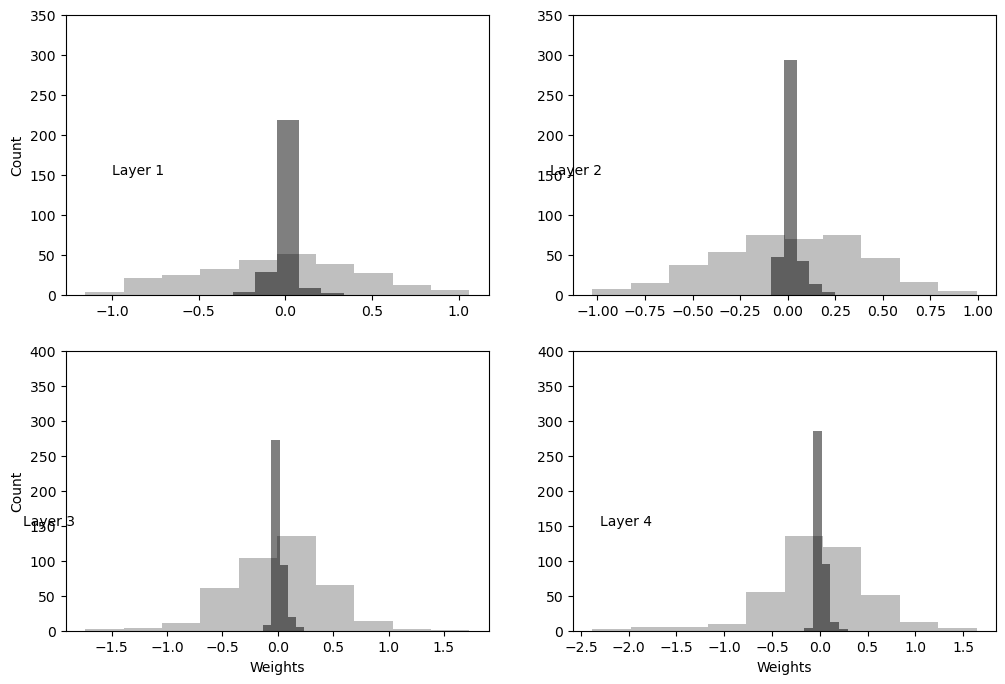

In [56]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(221)
plt.hist(weights1_notreg.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights1_reg.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_ylabel('Count')
ax.text(-1, 150, 'Layer 1')
plt.ylim(0, 350)

ax = fig.add_subplot(222)
plt.hist(weights2_notreg.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights2_reg.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.text(-1.25, 150, 'Layer 2')
plt.ylim(0, 350)

ax = fig.add_subplot(223)
plt.hist(weights3_notreg.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights3_reg.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_ylabel('Count')
ax.set_xlabel('Weights')
ax.text(-2.30, 150, 'Layer 3')
plt.ylim(0, 400)

ax = fig.add_subplot(224)
plt.hist(weights4_notreg.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights4_reg.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_xlabel('Weights')
ax.text(-2.30, 150, 'Layer 4')
plt.ylim(0, 400)

plt.show()

As you can see from the above plot, regularization effectively increases the number of weights which are zero, reducing overfitting by making the network simpler, without the need to change its architecture.

##### $\lambda = 0.0$ vs $\lambda = 3.0$, $1000$ epochs

Let us inspect another case, comparing a not regularized network with a regularized one, with $\lambda = 3.0$ and after 1000 epochs.

In [57]:
hist_notreg, model_notreg = create_and_train_reg_model_L2(train_x, train_y, dev_x, dev_y, 20, 4, 1000, 0.0)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  557.566162109375
Dev MSE =  583.5431518554688
Cost function at epoch 1000
Training MSE =  4.157875061035156
Dev MSE =  14.97035026550293


In [58]:
hist_reg, model_reg = create_and_train_reg_model_L2(train_x, train_y, dev_x, dev_y, 20, 4, 1000, 3.0)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  1123.5521240234375
Dev MSE =  1150.8675537109375
Cost function at epoch 1000
Training MSE =  48.77186965942383
Dev MSE =  54.53315353393555


In [59]:
# not regularized network
weights1_notreg = model_notreg.layers[1].get_weights()[0]
weights2_notreg = model_notreg.layers[2].get_weights()[0]
weights3_notreg = model_notreg.layers[3].get_weights()[0]
weights4_notreg = model_notreg.layers[4].get_weights()[0]

In [60]:
# regularized network
weights1_reg = model_reg.layers[1].get_weights()[0]
weights2_reg = model_reg.layers[2].get_weights()[0]
weights3_reg = model_reg.layers[3].get_weights()[0]
weights4_reg = model_reg.layers[4].get_weights()[0]

In [61]:
print('NOT REGULARIZED NETWORK')
print('First hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights1_notreg) < 1e-3)) / weights1_notreg.size * 100.0))
print('Second hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights2_notreg) < 1e-3)) / weights2_notreg.size * 100.0))
print('Third hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights3_notreg) < 1e-3)) / weights3_notreg.size * 100.0))
print('Fourth hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights4_notreg) < 1e-3)) / weights4_notreg.size * 100.0))

NOT REGULARIZED NETWORK
First hidden layer:
0.38
Second hidden layer:
0.50
Third hidden layer:
0.00
Fourth hidden layer:
0.50


In [62]:
print('REGULARIZED NETWORK')
print('First hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights1_reg) < 1e-3)) / weights1_reg.size * 100.0))
print('Second hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights2_reg) < 1e-3)) / weights2_reg.size * 100.0))
print('Third hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights3_reg) < 1e-3)) / weights3_reg.size * 100.0))
print('Fourth hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights4_reg) < 1e-3)) / weights4_reg.size * 100.0))

REGULARIZED NETWORK
First hidden layer:
1.54
Second hidden layer:
8.75
Third hidden layer:
26.00
Fourth hidden layer:
34.25


#### Training and Dev MSE vs. $\lambda$ Plot

**How can we choose $\lambda$?** A very useful **tip** may be to plot the behaviour of the MSE on the training and dev sets, given a specific network, for many $\lambda$ parameters.

Let us calculate the performances:

In [63]:
train_mse, dev_mse = [], []
lambda_values = [0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0]

for lambda_ in lambda_values:
  
  print('Lambda = ', lambda_)
  hist_, model_ = create_and_train_reg_model_L2(train_x, train_y, dev_x, dev_y, 20, 4, 1000, lambda_)
  train_mse.append(hist_['loss'].values[-1])
  dev_mse.append(hist_['val_loss'].values[-1])
  print()

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Lambda =  0.0


/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  551.8920288085938
Dev MSE =  573.0916137695312
Cost function at epoch 1000
Training MSE =  3.6075992584228516
Dev MSE =  18.92444610595703

Lambda =  2.5


/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  1019.0216674804688
Dev MSE =  1042.8819580078125
Cost function at epoch 1000
Training MSE =  44.649696350097656
Dev MSE =  50.307403564453125

Lambda =  5.0


/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  1343.921875
Dev MSE =  1367.5335693359375
Cost function at epoch 1000
Training MSE =  59.53509521484375
Dev MSE =  60.87730407714844

Lambda =  7.5


/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  1950.09716796875
Dev MSE =  1975.2054443359375
Cost function at epoch 1000
Training MSE =  79.14045715332031
Dev MSE =  78.52857971191406

Lambda =  10.0


/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  2372.861572265625
Dev MSE =  2395.23681640625
Cost function at epoch 1000
Training MSE =  93.89905548095703
Dev MSE =  91.5937271118164

Lambda =  12.5


/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  2667.22998046875
Dev MSE =  2686.339111328125
Cost function at epoch 1000
Training MSE =  103.14254760742188
Dev MSE =  100.34691619873047

Lambda =  15.0


/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  3039.463134765625
Dev MSE =  3050.50732421875
Cost function at epoch 1000
Training MSE =  113.43803405761719
Dev MSE =  111.1098861694336

Lambda =  17.5


/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  3215.259521484375
Dev MSE =  3227.532470703125
Cost function at epoch 1000
Training MSE =  118.40911865234375
Dev MSE =  115.86932373046875

Lambda =  20.0
Cost function at epoch 0
Training MSE =  3751.8076171875
Dev MSE =  3767.737060546875
Cost function at epoch 1000
Training MSE =  124.7829818725586
Dev MSE =  122.33910369873047



And let us plot the final result.

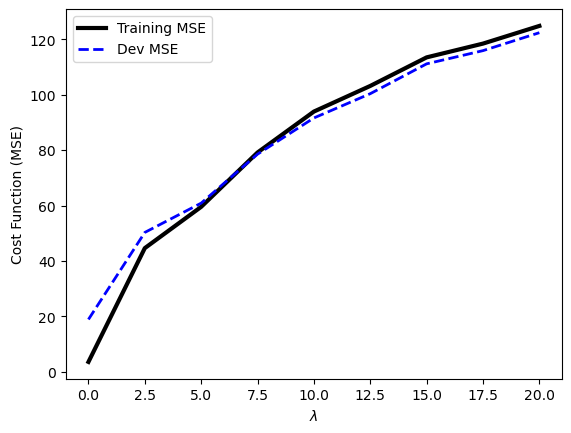

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(lambda_values, train_mse, ls = '-', color = 'black', lw = 3, label = 'Training MSE')
ax.plot(lambda_values, dev_mse, ls = '--', color = 'blue', lw = 2, label = 'Dev MSE')
plt.ylabel('Cost Function (MSE)')
plt.xlabel('$\lambda$')
ax.set_xticks(lambda_values)
plt.legend(loc = 'best')

plt.axis(True)
plt.show()

 As you can see, a good choice for the $\lambda$ parameter in this specific case (always remember that in the deep learning world there is no a unique rule) may be 6, since in this point the MSE on the training and on the dev datasets are almost the same. Before 6 in the plot, the model tends to overfit the data (since the error on the training is higher than the error on the dev set), while after 6 the model becomes too simple and cannot capture the main features of the dataset.

### $L_1$ Regularization Technique

As for $L_2$ regularization, the implementation in Keras is straightforward.

**${\bf L_1}$ regularization** also works by adding an additional term to the cost function:

$$
\tilde{J}({\bf w})={J({\bf w})+\frac{\lambda}{m}{||{\bf w}||}}_1
$$

As before, we will define $\lambda$ in Keras as an additional hyper-parameter and we will search for its optimal value (i.e. the one that prevents the network from going into overfitting regime). 

Notice that in Keras the $L_1$ regularization penalty is computed as: `loss = l1 * reduce_sum(abs(x))`.

In [65]:
def create_and_train_reg_model_L1(data_train_norm, labels_train, data_dev_norm, labels_dev, num_neurons, num_layers, n_epochs, lambda_):
    # build model
    inputs = keras.Input(shape = data_train_norm.shape[1]) # input layer
    # he initialization
    initializer = tf.keras.initializers.HeNormal()
    # regularization
    reg = tf.keras.regularizers.l1(l1 = lambda_)
    # first hidden layer
    dense = layers.Dense(num_neurons, activation = 'relu', kernel_initializer = initializer, kernel_regularizer = reg)(inputs)
    # customized number of layers and neurons per layer
    for i in range(num_layers - 1):       
        dense = layers.Dense(num_neurons, activation = 'relu', kernel_initializer = initializer, kernel_regularizer = reg)(dense)
    # output layer   
    outputs = layers.Dense(1)(dense)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'model')
    # set optimizer and loss
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'mse', optimizer = opt, metrics = ['mse'])
    
    # train model
    history = model.fit(
      data_train_norm, labels_train,
      epochs = n_epochs, verbose = 0,
      batch_size = data_train_norm.shape[0],
      validation_data = (data_dev_norm, labels_dev))
    # save performances
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch 
    # print performances
    print('Cost function at epoch 0')
    print('Training MSE = ', hist['loss'].values[0])
    print('Dev MSE = ', hist['val_loss'].values[0])
    print('Cost function at epoch ' + str(n_epochs))
    print('Training MSE = ', hist['loss'].values[-1])
    print('Dev MSE = ', hist['val_loss'].values[-1])

    return hist, model

The only change with respect to the function we wrote for implementing $L_2$ regularizer is in the definition of the regularizer itself. Very simple!!!

#### Number of Weights that are Zero

Let us evaluate and compare a situation in which the network is not regularized ($\lambda = 0.0$) and a situation in which we apply a regularization ($\lambda = 3.0$), printing on the screen the final loss function value in the case of the training and dev dataset.

##### $\lambda = 0.0$ vs $\lambda = 3.0$, $1000$ epochs

In [66]:
hist_notreg, model_notreg = create_and_train_reg_model_L1(train_x, train_y, dev_x, dev_y, 20, 4, 1000, 0.0)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  638.4248046875
Dev MSE =  663.7759399414062
Cost function at epoch 1000
Training MSE =  5.8754401206970215
Dev MSE =  17.62221336364746


In [67]:
hist_reg, model_reg = create_and_train_reg_model_L1(train_x, train_y, dev_x, dev_y, 20, 4, 1000, 3.0)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  1782.259033203125
Dev MSE =  1806.425048828125
Cost function at epoch 1000
Training MSE =  82.71393585205078
Dev MSE =  87.26091766357422


As expected, also $L_1$ regularization effectively deals with overfitting (by reducing the difference between the training and dev set performances).

Let us inspect how many weights are close to zero, like we did for $L_2$ regularizer.

In [68]:
# not regularized network
weights1_notreg = model_notreg.layers[1].get_weights()[0]
weights2_notreg = model_notreg.layers[2].get_weights()[0]
weights3_notreg = model_notreg.layers[3].get_weights()[0]
weights4_notreg = model_notreg.layers[4].get_weights()[0]

In [69]:
# regularized network
weights1_reg = model_reg.layers[1].get_weights()[0]
weights2_reg = model_reg.layers[2].get_weights()[0]
weights3_reg = model_reg.layers[3].get_weights()[0]
weights4_reg = model_reg.layers[4].get_weights()[0]

In [70]:
print('NOT REGULARIZED NETWORK')
print('First hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights1_notreg) < 1e-3)) / weights1_notreg.size * 100.0))
print('Second hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights2_notreg) < 1e-3)) / weights2_notreg.size * 100.0))
print('Third hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights3_notreg) < 1e-3)) / weights3_notreg.size * 100.0))
print('Fourth hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights4_notreg) < 1e-3)) / weights4_notreg.size * 100.0))

NOT REGULARIZED NETWORK
First hidden layer:
0.00
Second hidden layer:
0.00
Third hidden layer:
0.00
Fourth hidden layer:
0.00


In [71]:
print('REGULARIZED NETWORK')
print('First hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights1_reg) < 1e-3)) / weights1_reg.size * 100.0))
print('Second hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights2_reg) < 1e-3)) / weights2_reg.size * 100.0))
print('Third hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights3_reg) < 1e-3)) / weights3_reg.size * 100.0))
print('Fourth hidden layer:')
print('{:.2f}'.format((np.sum(np.abs(weights4_reg) < 1e-3)) / weights4_reg.size * 100.0))

REGULARIZED NETWORK
First hidden layer:
92.69
Second hidden layer:
95.75
Third hidden layer:
97.00
Fourth hidden layer:
93.25


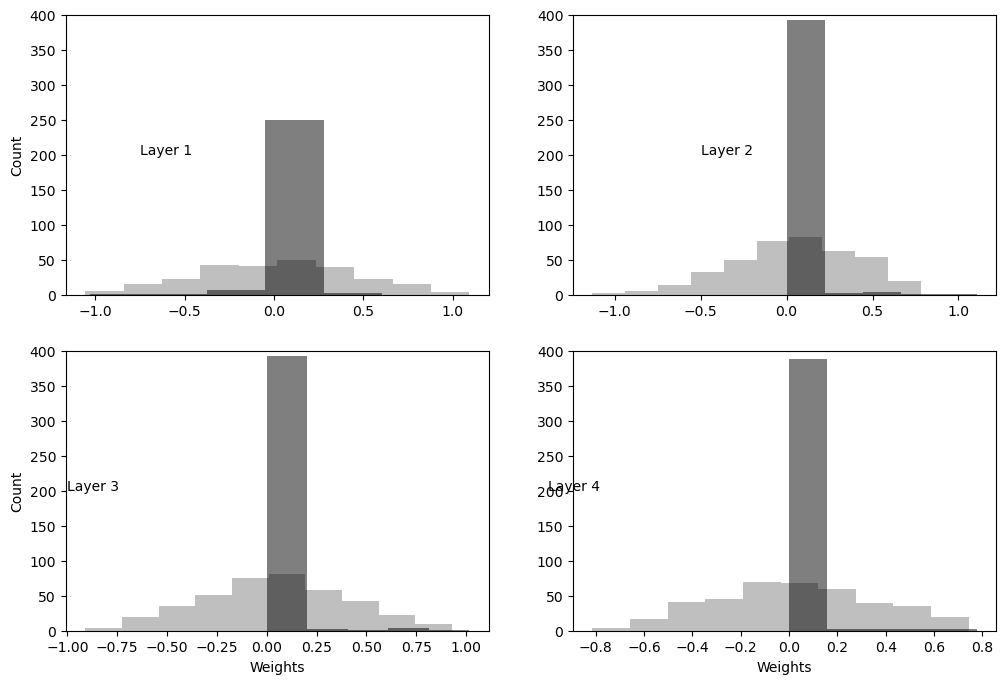

In [73]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(221)
plt.hist(weights1_notreg.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights1_reg.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_ylabel('Count')
ax.text(-0.75, 200, 'Layer 1')
plt.ylim(0, 400)

ax = fig.add_subplot(222)
plt.hist(weights2_notreg.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights2_reg.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.text(-0.5, 200, 'Layer 2')
plt.ylim(0, 400)

ax = fig.add_subplot(223)
plt.hist(weights3_notreg.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights3_reg.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_ylabel('Count')
ax.set_xlabel('Weights')
ax.text(-1, 200, 'Layer 3')
plt.ylim(0, 400)

ax = fig.add_subplot(224)
plt.hist(weights4_notreg.flatten(), alpha = 0.25, bins = 10, color = 'black')
plt.hist(weights4_reg.flatten(), alpha = 0.5, bins = 5, color = 'black')
ax.set_xlabel('Weights')
ax.text(-1, 200, 'Layer 4')
plt.ylim(0, 400)

plt.show()

### Are the weights really going to zero?

We are now using a simulated dataset to visually see how fast the weights of a regularized deep neural network goes to zero.

In [74]:
nobs = 30 # number of observations
np.random.seed(42) # making results reproducible

# first set of observations
xx1 = np.array([np.random.normal(0.3, 0.15) for i in range (0, nobs)])
yy1 = np.array([np.random.normal(0.3, 0.15) for i in range (0, nobs)])
# second set of observations
xx2 = np.array([np.random.normal(0.1, 0.1) for i in range (0, nobs)])
yy2 = np.array([np.random.normal(0.3, 0.1) for i in range (0, nobs)])
# concatenating observations
c1_ = np.c_[xx1.ravel(), yy1.ravel()]
c2_ = np.c_[xx2.ravel(), yy2.ravel()] 
c = np.concatenate([c1_, c2_])
# creating the labels
yy1_ = np.full(nobs, 0, dtype = int)
yy2_ = np.full(nobs, 1, dtype = int)
yyL = np.concatenate((yy1_, yy2_), axis = 0)
# defining training points and labels
train_x = c
train_y = yyL

Our dataset has two features: $x$ and $y$. Two group of points have been generated from a normal distribution:
- (`xx1`, `yy1`), of class 0 
- (`xx2`, `yy2`), of class 1

We will follow the behaviour of a specific weight ($w_{12,5}^{[3]}$ from layer 3) along the 1000 epochs. The network has been $L_2$-regularized ($\lambda=0.1$).

To get weights for every epoch from a Keras model it is necessary to use a **callback function**. We are not going into the details of callback functions here, since they are widely explained in another Chapter, specifically dedicated to them. The only thing you need to know now is that Keras does not automatically save each weight's value during training. To have them, we need to use callbacks.



With the following code we train the model for binary classification and we save the weights for each epoch.

In [75]:
weights_dict = {}
weight_history = []

In [76]:
# build model
inputs = keras.Input(shape = train_x.shape[1]) # input layer
# he initialization
initializer = tf.keras.initializers.HeNormal()
# regularization
reg = tf.keras.regularizers.l2(l2 = 0.1)
# hidden layers
dense = layers.Dense(20, activation = 'relu', kernel_initializer = initializer, kernel_regularizer = reg)(inputs)
dense = layers.Dense(20, activation = 'relu', kernel_initializer = initializer, kernel_regularizer = reg)(dense)
dense = layers.Dense(20, activation = 'relu', kernel_initializer = initializer, kernel_regularizer = reg)(dense)
dense = layers.Dense(20, activation = 'relu', kernel_initializer = initializer, kernel_regularizer = reg)(dense)    
# output layer   
outputs = layers.Dense(1, activation = 'sigmoid')(dense)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'model')
# set optimizer and loss
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
# set callback function
weight_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end = lambda epoch, logs: weights_dict.update({epoch: model.get_weights()}))
# train model
history = model.fit(
  train_x, train_y,
  epochs = 1000, verbose = 0,
  batch_size = train_x.shape[0],
  callbacks = weight_callback)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


We then keep the values of the specific weight we are interested in.

In [77]:
# retrieve weights
for epoch, weights in weights_dict.items():
  weight_history.append(weights[6][5][12])

Finally we plot the weight's decay rate.

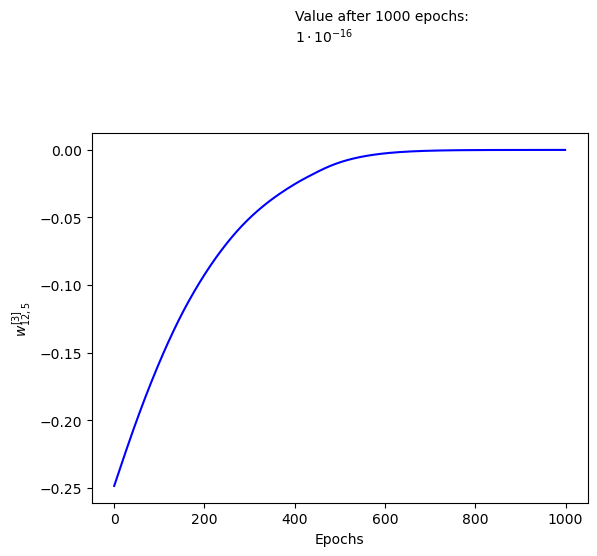

In [79]:
# Weight's value vs. number of epoch plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(weight_history, color = 'blue')
plt.ylabel('$w^{[3]}_{12,5}$')
plt.xlabel('Epochs')
ax.text(400, 0.08, 'Value after 1000 epochs:\n$1\cdot 10^{-16}$')

#plt.savefig('./Figure16-9.png', dpi = 300)
plt.show()

As you can notice, the weights really go down to zero and also very fast. How fast? Exponentially.

### Dropout

Another regularization technique is called dropout and its basic idea is the following: during the training phase of a deep neural network, nodes are removed randomly (with a specified probability $p^{[l]}$) from layer $l$.

In Keras, you simply add how many dropout layers as you want after the layer you want to *drop*, with the following function: `keras.layers.Dropout(rate)`.

In the above function you must put as input the layer you want to *drop* and you must set the `rate` parameter. This parameter can assume float values in the following range: $[0, 1)$, since it represents the fraction of the input units to drop. Therefore, it is not possible to drop all the units (setting a rate equal to 1).

Now, let us compare the results when applying or not dropout to the Boston dataset.

In [95]:
#
# IMPORTANT: This cell is only for compatibility with older version of this notebook.
#

np.random.seed(42)
train_x = X_train_norm
train_y = y_train
dev_x = X_test_norm
dev_y = y_test

print(train_x.shape)
print(train_y.shape)
print(dev_x.shape)
print(dev_y.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [98]:
def create_and_train_reg_model_dropout(data_train_norm, labels_train, data_dev_norm, labels_dev, num_neurons, num_layers, n_epochs, rate):
    # build model
    inputs = keras.Input(shape = data_train_norm.shape[1]) # input layer
    # he initialization
    initializer = tf.keras.initializers.HeNormal()
    # first hidden layer
    dense = layers.Dense(num_neurons, activation = 'relu', kernel_initializer = initializer)(inputs)
    # first dropout layer
    dense = keras.layers.Dropout(rate)(dense)
    # customized number of layers and neurons per layer
    for i in range(num_layers - 1):   
        dense = layers.Dense(num_neurons, activation = 'relu', kernel_initializer = initializer)(dense)
        # customized number of dropout layers  
        dense = keras.layers.Dropout(rate)(dense)
    # output layer   
    outputs = layers.Dense(1)(dense)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'model')
    # set optimizer and loss
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'mse', optimizer = opt, metrics = ['mse'])
    
    # train model
    history = model.fit(
      data_train_norm, labels_train,
      epochs = n_epochs, verbose = 0,
      batch_size = data_train_norm.shape[0],
      validation_data = (data_dev_norm, labels_dev))
    # save performances
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch 
    # print performances
    print('Cost function at epoch 0')
    print('Training MSE = ', hist['loss'].values[0])
    print('Dev MSE = ', hist['val_loss'].values[0])
    print('Cost function at epoch ' + str(n_epochs))
    print('Training MSE = ', hist['loss'].values[-1])
    print('Dev MSE = ', hist['val_loss'].values[-1])

    return hist, model

In [99]:
hist_notreg, model_notreg = create_and_train_reg_model_dropout(train_x, train_y, dev_x, dev_y, 20, 4, 8000, 0.0)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  604.5191650390625
Dev MSE =  631.0469360351562
Cost function at epoch 8000
Training MSE =  0.0625985786318779
Dev MSE =  30.252704620361328


In [100]:
hist_reg, model_reg = create_and_train_reg_model_dropout(train_x, train_y, dev_x, dev_y, 20, 4, 8000, 0.50)

/Users/umberto/miniforge3/envs/tf-jan24/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cost function at epoch 0
Training MSE =  540.6317138671875
Dev MSE =  565.3737182617188
Cost function at epoch 8000
Training MSE =  53.6318359375
Dev MSE =  69.57634735107422


In the following plot you can see the training dataset cost function vs. the number of epoch in the case of a model without regularization and another one with a dropout rate of 0.50.

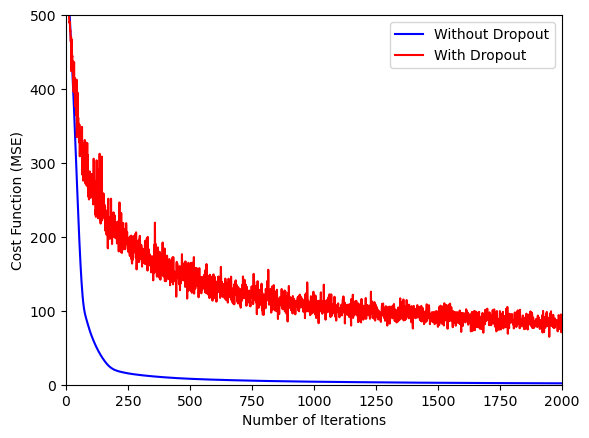

In [103]:
# Cost function vs. number of epoch plot for a model trained with dropout and another one trained without dropout

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(hist_notreg['loss'], color = 'blue', label = 'Without Dropout')
ax.plot(hist_reg['loss'], color = 'red', label = 'With Dropout')
plt.ylabel('Cost Function (MSE)')
plt.xlabel('Number of Iterations')
ax.set_xlim(0, 2000)
ax.set_ylim(0, 500)
plt.legend(loc = 'best')

plt.axis(True)
plt.show()

As you can see, when applying dropout, the cost function is very irregular. Let us now plot the cost function on the training and dev datasets, comparing them both when applying dropout and when not.

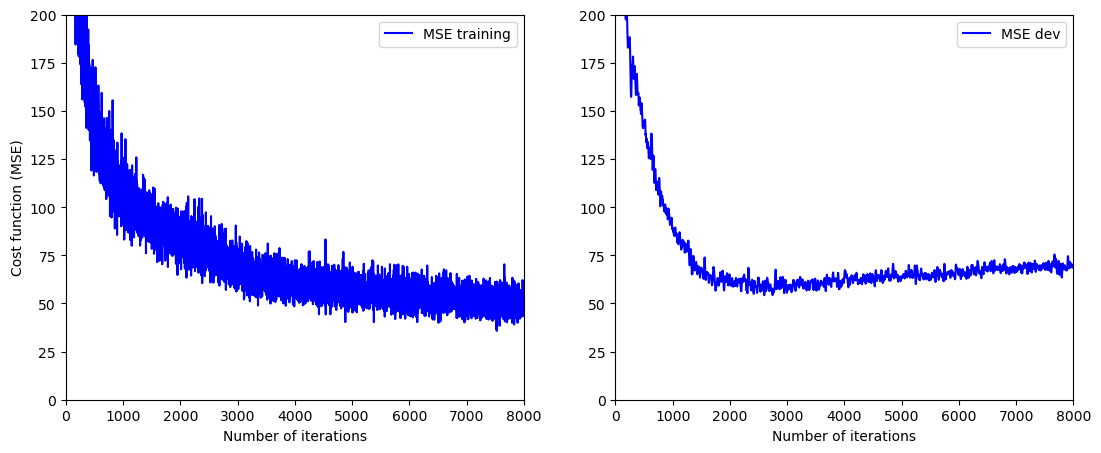

In [104]:
# cost function vs. number of epochs plot for training and dev datasets
# with dropout

fig = plt.figure(figsize = (13, 5))
ax = fig.add_subplot(121)

ax.plot(hist_reg['loss'], color = 'blue', label = 'MSE training')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Cost function (MSE)')
ax.set_xlim(0, 8000)
ax.set_ylim(0, 200)
ax.legend(loc = 'best')

ax = fig.add_subplot(122)
ax.plot(hist_reg['val_loss'], color = 'blue', label = 'MSE dev')
ax.set_xlabel('Number of iterations')
ax.set_xlim(0, 8000)
ax.set_ylim(0, 200)
ax.legend(loc = 'best')

plt.axis(True)
plt.show()

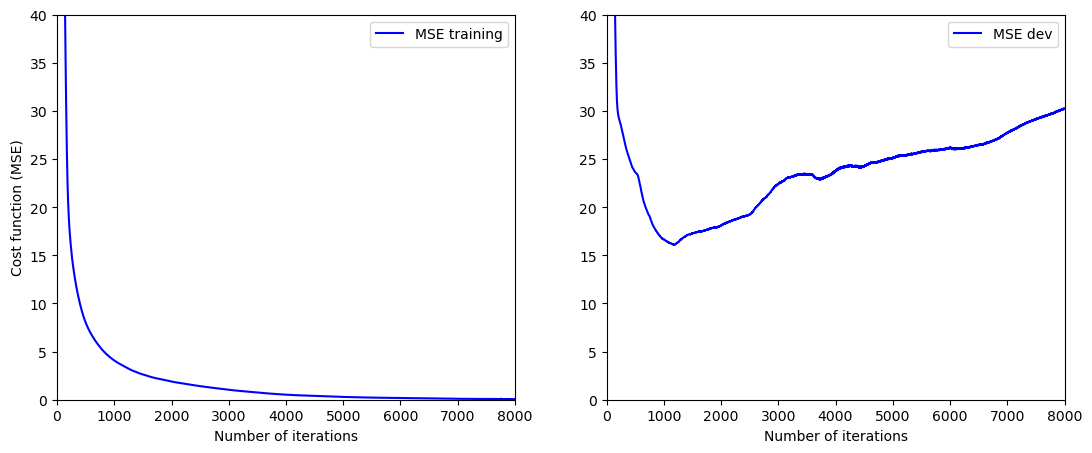

In [105]:
# cost function vs. number of epochs plot for training and dev datasets
# without dropout

fig = plt.figure(figsize = (13, 5))
ax = fig.add_subplot(121)

ax.plot(hist_notreg['loss'], color = 'blue', label = 'MSE training')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Cost function (MSE)')
ax.set_xlim(0, 8000)
ax.set_ylim(0, 40)
ax.legend(loc = 'best')

ax = fig.add_subplot(122)
ax.plot(hist_notreg['val_loss'], color = 'blue', label = 'MSE dev')
ax.set_xlabel('Number of iterations')
ax.set_xlim(0, 8000)
ax.set_ylim(0, 40)
ax.legend(loc = 'best')

plt.axis(True)
plt.show()

The difference between the two above plots is evident: it is very interesting the fact that without dropout $MSE_{dev}$ grows with epochs, while using dropout it is rather stable. Without dropout, the model is in clear extreme overfitting regime, while with dropout you can see how the $MSE_{train}$ and $MSE_{dev}$ are of the same order of magnitude and the $MSE_{dev}$ does not continue to grow, so we have a model that is a lot better at generalizing. 

### Early Stopping

Now the last technique that is sometime used to fight overfitting is early stopping. Strictly speaking this method does nothing to avoid overfitting, it simply stops the learning before the overfitting problem becomes too bad. In the above considered example, we can decide to stop the training phase when the $MSE_{dev}$ reaches its minimum, as the red vertical line in the following plot indicates.

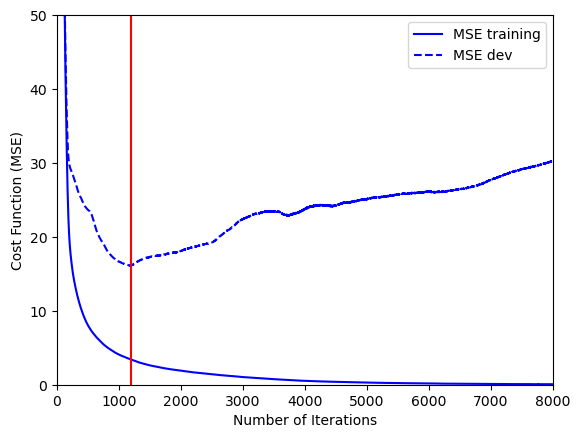

In [106]:
# Cost function vs. number of epoch plot for a model trained with dropout and another one trained without dropout

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(hist_notreg['loss'], ls = '-', color = 'blue', label = 'MSE training')
ax.plot(hist_notreg['val_loss'], ls = '--', color = 'blue', label = 'MSE dev')
plt.vlines(np.argmin(hist_notreg['val_loss'].values), 0, 50, color = 'red')
plt.ylabel('Cost Function (MSE)')
plt.xlabel('Number of Iterations')
ax.set_xlim(0, 8000)
ax.set_ylim(0, 50)
plt.legend(loc = 'best')

plt.axis(True)
plt.show()

Note that this is not an ideal way of solving the overfitting problem. Your model will still most probably generalize very badly to new data. It is usually preferable to use other techniques. Additionally, this is also time consuming and a manual process that is very error prone. 

## Exercises

1. [*Easy Difficulty*] Try to determine which architecture (number of layers and number of neurons) is not overfitting the Boston dataset. When the network starts overfitting? Which network would give a good result? Try (**at least**) the following combinations:

| Number of layers | Number of neurons for each layer |
| --- | --- |
| 1 | 3 |
| 1 | 5 |
| 2 | 3 |
| 2 | 5 |

2. [*Medium Difficulty*] Find the minimum value for $\lambda$ (in the case of $L_2$ regularization) for which the overfitting stops. Perform a set of tests using the function `hist, model = create_and_train_reg_model_L2(train_x, train_y, dev_x, dev_y, 20, 4, 0.0)` varying the value of $\lambda$ from 0 to 10.0 in regular increment (you can decide what values you want to test). Use at minimum the values: 0, 0.5, 1.0, 2.0, 5.0, 7.0, 10.0, 15.0. After that, make a plot of the value for the cost function on the training dataset and on the dev dataset vs. $\lambda$.

3. [*Medium Difficulty*] In $L_1$ regularization example applied to the Boston dataset, plot the amount of weights close to zero in hidden layer 3 vs. $\lambda$. Considering only layer 3, plot the quantity `(np.sum(np.abs(weights3) < 1e-3)) / weights3.size * 100.0`
we have evaluated before and calculate it for several values of $\lambda$. Consider at least: 0, 0.5, 1.0, 2.0, 5.0, 7.0, 10.0, 15.0. Plot then the value vs. $\lambda$. What shape do the curve have? Does it flatten out?

4. [*Hard Difficulty*] Implement $L_2$ regularization from scratch.

## Further Readings <a name = "fr"></a>

**Boston dataset**

1. Delve (Data for Evaluating Learning in Valid Experiments), “The Boston Housing Dataset”, www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

**Regularization**

1. Bishop, C.M, (1995) Neural Networks for Pattern Recognition, Oxford University Press
2. Goodfellow, I.J. et al., Deep Learning, MIT Press
3. Kukačka, J. et al., Regularization for deep learning: a taxonomy, arXiv: 1710.10686v1, available here: https://goo.gl/wNkjXz
